In [25]:
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

import torch.utils.data
from torch.utils.data import DataLoader
from collections import Counter

from utils import EmotionsDataset, SimpleNet, AttentionalNet

In [26]:
# define dictionary for emotions
emotion_dict = {0: 'Angry', 
                1: 'Disgust', 
                2: 'Fear',
                3: 'Happy', 
                4: 'Sad',
                5: 'Surprise',
                6: 'Neutral'}

In [33]:
batch_size = 128
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])
dataset_train = EmotionsDataset(root='./dataset', fname='icml_face_data_train.csv', transform=transform)
dataset_validation = EmotionsDataset(root='./dataset', fname='icml_face_data_validation.csv', transform=transform)
dataset_test = EmotionsDataset(root='./dataset', fname='icml_face_data_test.csv', transform=transform)

Loading dataset...	Done
Loading dataset...	Done
Loading dataset...	Done


In [39]:
torch.manual_seed(0)
trainloader = DataLoader(dataset_train, batch_size = batch_size,shuffle=True,num_workers=0)
valloader = DataLoader(dataset_validation, batch_size = batch_size,shuffle=True,num_workers=0)
testloader = DataLoader(dataset_test, batch_size = batch_size)

In [40]:
for i in trainloader:
    print(i)

[tensor([[[[ 0.3961,  0.3961,  0.4039,  ..., -0.6706, -0.6235, -0.6157],
          [ 0.3882,  0.3961,  0.3961,  ..., -0.6863, -0.6314, -0.6235],
          [ 0.3882,  0.3961,  0.3961,  ..., -0.6706, -0.6471, -0.6000],
          ...,
          [ 0.3725,  0.3804,  0.3804,  ..., -0.6000, -0.6392, -0.5765],
          [ 0.3882,  0.3961,  0.3961,  ..., -0.6314, -0.7176, -0.2941],
          [ 0.3804,  0.3882,  0.3961,  ..., -0.7333, -0.5765,  0.0745]]],


        [[[-0.4588, -0.7176, -0.7412,  ..., -0.3255, -0.3569, -0.9373],
          [-0.5843, -0.8196, -0.5843,  ..., -0.4275, -0.1059, -0.7569],
          [-0.7098, -0.7647, -0.5137,  ..., -0.3882, -0.2000, -0.3882],
          ...,
          [-0.9059, -0.9059, -0.9686,  ..., -0.3412, -0.3020, -0.5216],
          [-0.8745, -0.8902, -0.9608,  ..., -0.2863, -0.3569, -0.4745],
          [-0.8745, -0.8902, -0.9529,  ..., -0.2549, -0.3804, -0.3961]]],


        [[[-0.8196, -0.7961, -0.8275,  ..., -0.7882, -0.7490, -0.7647],
          [-0.8353, -0.83

In [41]:
class Face_Emotion_CNN(nn.Module):
    def __init__(self):
        super(Face_Emotion_CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5,padding=3)
        self.cnn2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4,padding=2)
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5,padding=3)
        self.cnn4 = nn.Conv2d(in_channels=64, out_channels=128,kernel_size=5,padding=3)

        
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(3,stride=2)
        self.cnn1_bn = nn.BatchNorm2d(32)
        self.cnn2_bn = nn.BatchNorm2d(32)
        self.cnn3_bn = nn.BatchNorm2d(64)
        self.cnn4_bn = nn.BatchNorm2d(128)
       

        self.fc1 = nn.Linear(128*3*3, 1024)
        self.fc2 = nn.Linear(1024, 7)
        self.dropout = nn.Dropout(0.3)
        self.log_softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.relu(self.pool(self.cnn1_bn(self.cnn1(x))))
        #print(x.shape)
        x = self.relu(self.pool(self.cnn2_bn(self.cnn2(x))))
        #print(x.shape)
        x = self.relu(self.pool(self.cnn3_bn(self.cnn3(x))))
        #print(x.shape)
        x = self.relu(self.pool(self.cnn4_bn(self.cnn4(x))))
        #print(x.shape)
        #print(x.shape)

        #x = x.view(x.size(0), -1)
        x = x.reshape(x.shape[0],128*3*3)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(self.dropout(x)))
        x = self.log_softmax(x)
        return x

torch.manual_seed(0)
model = Face_Emotion_CNN()

In [42]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

#class_count = [i for i in Counter(dataset_train.targets).values()]
#weight = torch.tensor(class_count) / sum(class_count)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

In [43]:
no_epochs = 20
training_loss = []
val_loss = []
val_acc = []
train_acc = []

for epoch in range(no_epochs): 
    scheduler.step()
    running_loss = 0.0
    running_loss_val = 0
    running_loss_train = 0
    correct_val = 0
    total_val = 0
    total_train = 0 
    correct_train = 0
    #print(f"Epoch {epoch+1}")
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        

        running_loss += loss.item()
        #if i % 2000 == 1999:    # print every 2000 mini-batches
            #print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')

    with torch.no_grad():
        for traindata in trainloader:
            trainimages, trainlabels = traindata
            trainoutputs = model(trainimages)
            loss_train = criterion(trainoutputs, trainlabels)
            running_loss_train += loss_train.item()
            train_, trainpredicted = torch.max(trainoutputs.data, 1)
            total_train += trainlabels.size(0)
            correct_train += (trainpredicted == trainlabels).sum().item()
            
    with torch.no_grad():
        for valdata in valloader:
            valimages, vallabels = valdata
            valoutputs = model(valimages)
            loss_val = criterion(valoutputs, vallabels)
            running_loss_val += loss_val.item()
            val_, valpredicted = torch.max(valoutputs.data, 1)
            total_val += vallabels.size(0)
            correct_val += (valpredicted == vallabels).sum().item()
    
    print(correct_val/total_val)
    training_loss.append(running_loss)
    val_loss.append(running_loss_val)
    val_acc.append(correct_val/total_val)
    train_acc.append(correct_train/total_train)

print('Finished Training')



0.48258567846196715
0.5082195597659516
0.5363611033714126
0.5324602953468933
0.5773195876288659
0.5795486207857342
0.5865143494009474
0.5876288659793815
0.5926441905823349
0.5870716076901644
0.5873502368347729
0.5926441905823349
0.5923655614377263
0.5895792699916411
0.5906937865700752
0.5895792699916411
0.5887433825578156
0.5901365282808582
0.5906937865700752
0.5865143494009474
Finished Training


In [50]:
PATH = './6_layer_val_nowd_norandomness.pth'
torch.save(model.state_dict(), PATH)

In [51]:
#model = Face_Emotion_CNN()
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [44]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total} %')

Accuracy of the network on the test images: 60.713290610197824 %


In [45]:
classes = ('Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral')

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}


with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Angry is 54.8 %
Accuracy for class: Disgust is 29.1 %
Accuracy for class: Fear  is 35.6 %
Accuracy for class: Happy is 85.1 %
Accuracy for class: Sad   is 48.8 %
Accuracy for class: Surprise is 70.9 %
Accuracy for class: Neutral is 59.6 %


(0.0, 1.0)

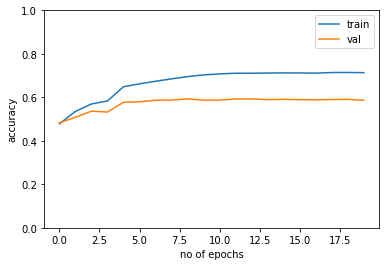

In [46]:
#plt.plot(training_loss)
plt.ylabel("accuracy")
plt.xlabel("no of epochs")
plt.plot(train_acc,label="train")
plt.plot(val_acc,label="val")
plt.legend(["train","val"])
plt.ylim((0,1))

<AxesSubplot:>

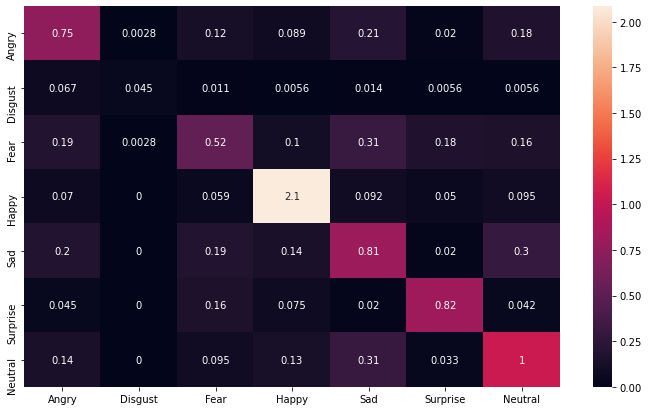

In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sn


y_pred = []
y_true = []

# iterate over test data
for inputs, labels in testloader:
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth


# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

<AxesSubplot:>

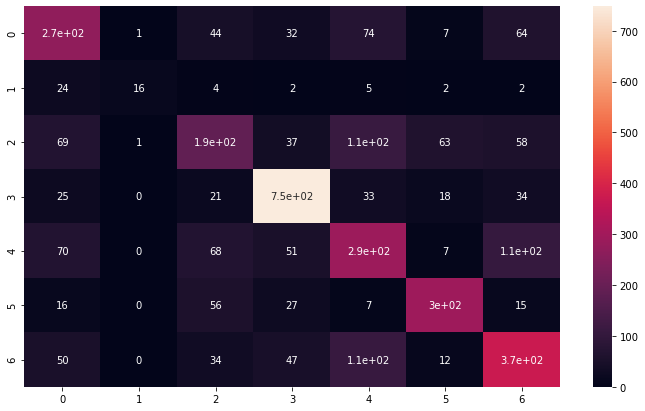

In [48]:
plt.figure(figsize = (12,7))
sn.heatmap(cf_matrix, annot=True)

In [49]:
cf_matrix

array([[269,   1,  44,  32,  74,   7,  64],
       [ 24,  16,   4,   2,   5,   2,   2],
       [ 69,   1, 188,  37, 112,  63,  58],
       [ 25,   0,  21, 748,  33,  18,  34],
       [ 70,   0,  68,  51, 290,   7, 108],
       [ 16,   0,  56,  27,   7, 295,  15],
       [ 50,   0,  34,  47, 110,  12, 373]], dtype=int64)